In [ ]:
!pip install pyspark
!pip install dataprep
!pip install pyspark[pandas_on_spark] plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 16.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=e5f44d6f42a08ce009cdeae76d4c0e2b1eff8c5725672b4d1be744e0748e09d1
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.1 MB/s e

In [ ]:
import pyspark
from pyspark.sql.functions import col
from pyspark.sql.functions import when
from dataprep.eda import create_report
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from sklearn.preprocessing import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
from pyspark.sql.functions import substring, expr

from google.colab import drive
drive.mount('/content/drive')

spark = pyspark.sql.SparkSession.builder.appName("eCommerce data").getOrCreate()

oct_df_path="/content/drive/MyDrive/Dataset/cie427_big_data/2019-Oct.csv"
nov_df_path="/content/drive/MyDrive/Dataset/cie427_big_data/2019-Nov.csv"
oct_df_million_path="/content/drive/MyDrive/Dataset/cie427_big_data/oct_df_million.csv"
output_path = "/content/drive/MyDrive/Dataset/cie427_big_data/"

Mounted at /content/drive


In [ ]:
df = spark.read.option("header",True).csv(oct_df_million_path)

#df.to_csv("oct_df_million.csv",index=False)

df.head(10)

[Row(event_time='2019-10-01 00:00:00 UTC', event_type='view', product_id='44600062', category_id='2103807459595387724', category_code=None, brand='shiseido', price='35.79', user_id='541312140', user_session='72d76fde-8bb3-4e00-8c23-a032dfed738c'),
 Row(event_time='2019-10-01 00:00:00 UTC', event_type='view', product_id='3900821', category_id='2053013552326770905', category_code='appliances.environment.water_heater', brand='aqua', price='33.2', user_id='554748717', user_session='9333dfbd-b87a-4708-9857-6336556b0fcc'),
 Row(event_time='2019-10-01 00:00:01 UTC', event_type='view', product_id='17200506', category_id='2053013559792632471', category_code='furniture.living_room.sofa', brand=None, price='543.1', user_id='519107250', user_session='566511c2-e2e3-422b-b695-cf8e6e792ca8'),
 Row(event_time='2019-10-01 00:00:01 UTC', event_type='view', product_id='1307067', category_id='2053013558920217191', category_code='computers.notebook', brand='lenovo', price='251.74', user_id='550050854', use

#### take a look at the dataframe

In [ ]:
df.show(5)

+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 00:00:...|      view|  44600062|2103807459595387724|                null|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 00:00:...|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 00:00:...|      view|  17200506|2053013559792632471|furniture.living_...|    null|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 00:00:...|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 00:00:...|      view|   1004237|205301355563188265

#### filter out null categories

In [ ]:
df_not_null = df.where(col("category_code") != "null")

#### only keep one entry per user, product, and event

In [ ]:
df_final = df_not_null.dropDuplicates(subset=['user_id', 'product_id', 'event_type'])

#### correct data by replacing category_code "construction.tools.light" by "electronics.smartphone"

In [ ]:
df_corrected = df_final.withColumn("category_code",
                                      when(col("category_code") == "construction.tools.light",
                                           "electronics.smartphone").otherwise(col("category_code")))

#Exploratory Data Analysis (EDA)

In [ ]:
df_market = df
df_market = df_market.dropDuplicates()
#df_market=df_market.drop(*['event_time','product_id', 'user_id', 'user_session'])

In [ ]:
from pyspark.sql.functions import sum
df_market.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_market.columns)).show()

+----------+----------+----------+-----------+-------------+------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code| brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+------+-----+-------+------------+
|         0|         0|         0|          0|       318053|147550|    0|      0|           0|
+----------+----------+----------+-----------+-------------+------+-----+-------+------------+



In [ ]:
df_market = df_market.dropna()
df_market.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_market.columns)).show()

+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|         0|         0|         0|          0|            0|    0|    0|      0|           0|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+



In [ ]:
df_market.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



In [ ]:
df_pandas = df_market.select(substring(col("price").cast("float"), 0, 10).alias("avg_price"), substring(col("event_time"), 0, 10).alias("day")).toPandas()


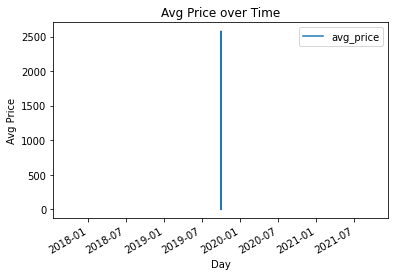

In [ ]:

# convert the column to numeric data type
df_pandas['avg_price'] = pd.to_numeric(df_pandas['avg_price'], errors='coerce')
df_pandas['day'] = pd.to_datetime(df_pandas['day'])

# Set the 'day' column as the index
df_pandas.set_index('day', inplace=True)

# Plot the data
df_pandas.plot()
plt.xlabel("Day")
plt.ylabel("Avg Price")
plt.title("Avg Price over Time")
plt.show()

In [ ]:
df_2 = df_market.select(col("price").cast("float").alias("avg_price")).toPandas()
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627805 entries, 0 to 627804
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   avg_price  627805 non-null  float32
dtypes: float32(1)
memory usage: 2.4 MB


In [ ]:
from pyspark.sql.functions import floor
from pyspark.sql.functions import col

#col("price").cast("float").alias("avg_price")

df_samsung_purchase = df_market.select(
    col("category_code").alias("code"), 
    col("brand").alias("brand")
).where(
    (col("event_type") == 'purchase')
).toPandas()

print(df_samsung_purchase)


                                code    brand
0             electronics.smartphone  samsung
1             electronics.smartphone    apple
2             electronics.smartphone    apple
3             electronics.smartphone    apple
4      computers.peripherals.printer    epson
...                              ...      ...
12824   construction.tools.generator  polaris
12825         electronics.smartphone  samsung
12826                  apparel.shoes  respect
12827         electronics.smartphone     oppo
12828         electronics.smartphone  samsung

[12829 rows x 2 columns]


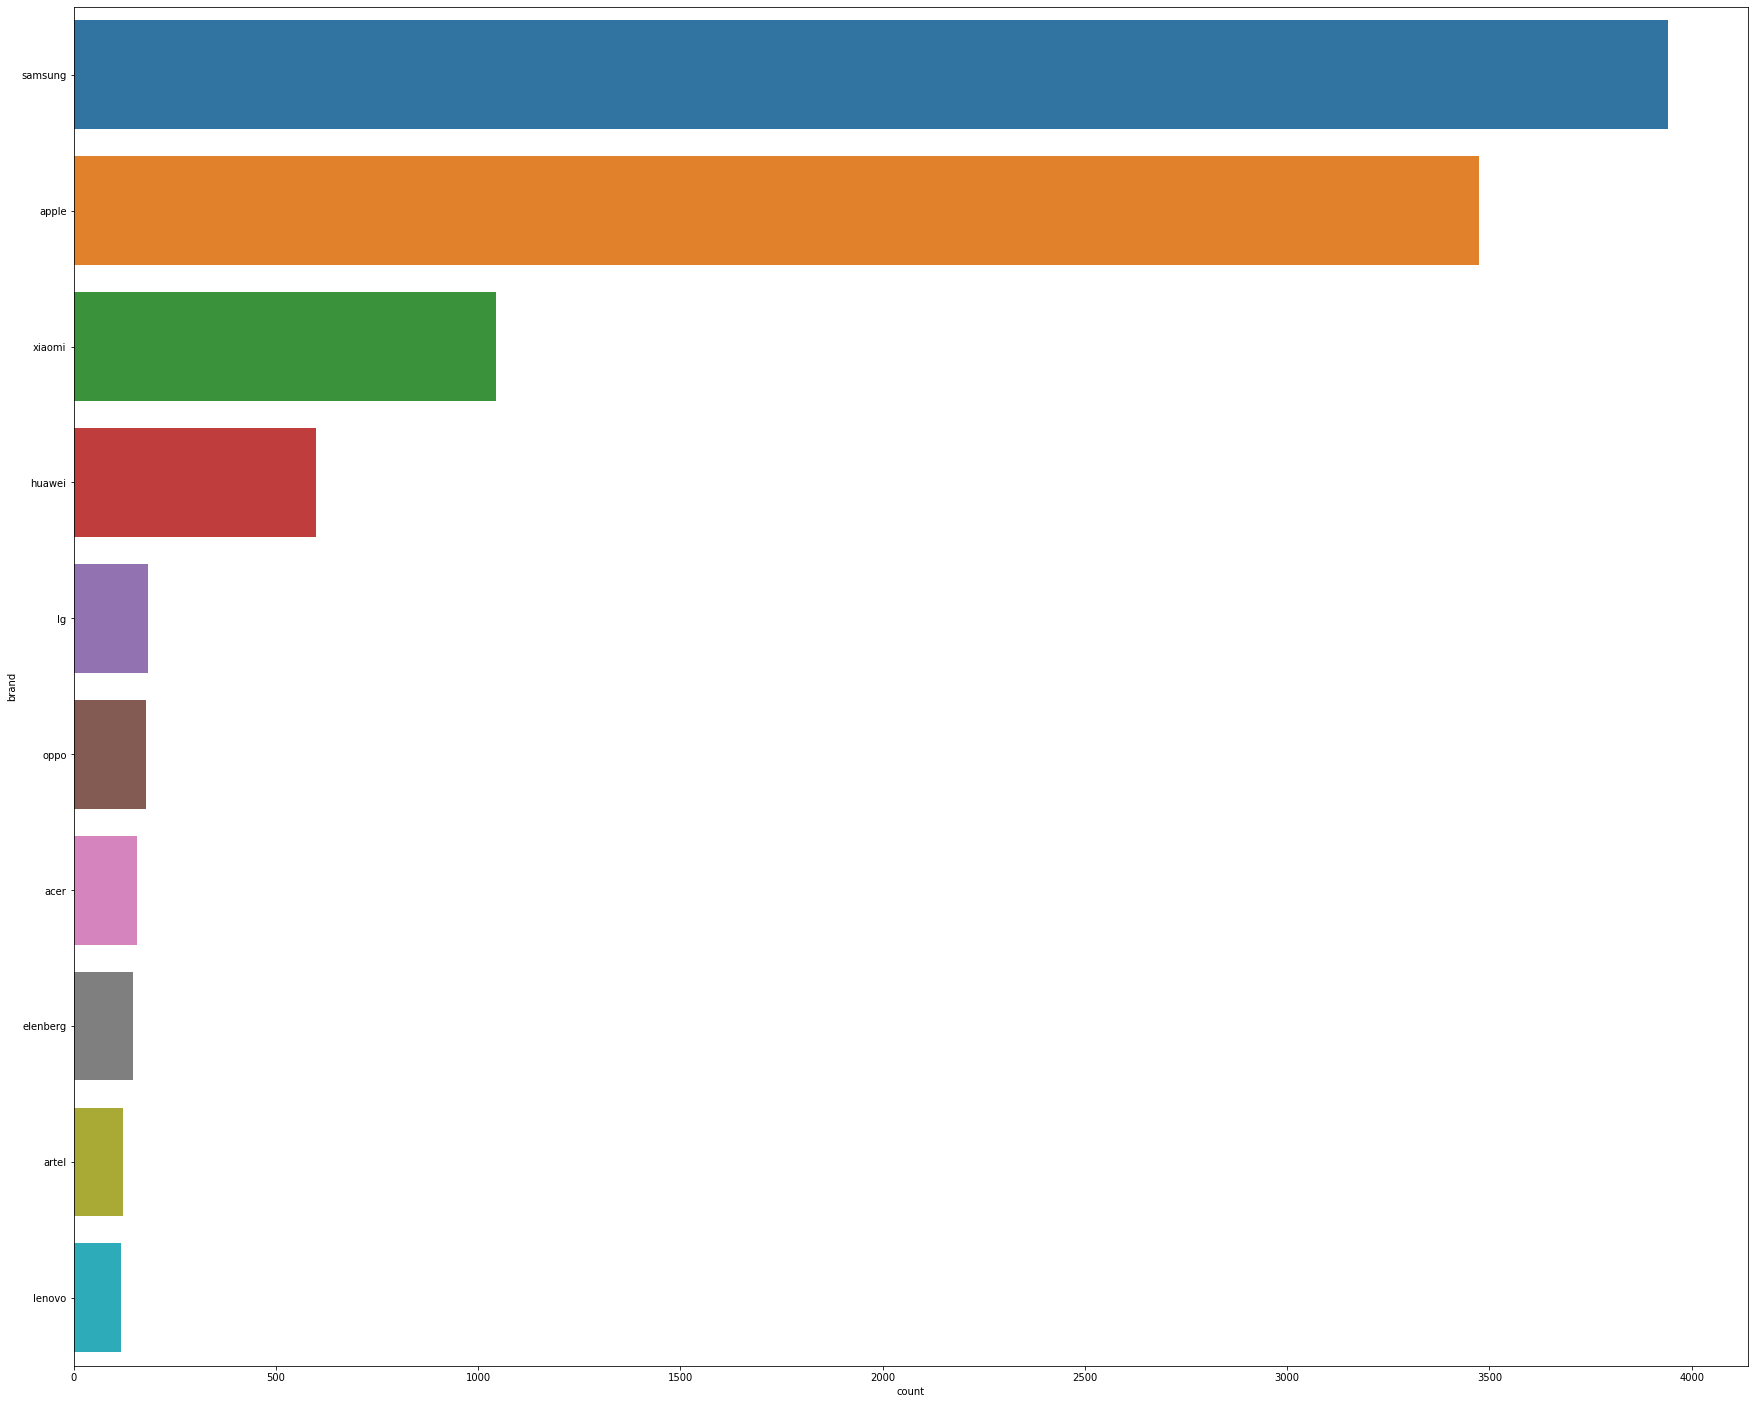

In [ ]:
import matplotlib.pyplot as plt

# Count the values in the two columns
df_plot = df_samsung_purchase.groupby(['code','brand']).size().reset_index(name='counts')


import seaborn as sns
top_10_brands = df_samsung_purchase['brand'].value_counts().nlargest(10)
plt.figure(figsize=(30,25))
sns.countplot(y='brand', data=df_samsung_purchase, order=top_10_brands.index)

In [ ]:
df_samsung_purchase['code'].unique()

array(['electronics.smartphone', 'computers.peripherals.printer',
       'electronics.audio.subwoofer', 'electronics.clocks',
       'computers.components.memory', 'appliances.kitchen.mixer',
       'appliances.personal.hair_cutter', 'electronics.video.tv',
       'computers.notebook', 'appliances.environment.water_heater',
       'computers.peripherals.monitor', 'computers.desktop',
       'appliances.kitchen.hood', 'construction.tools.painting',
       'accessories.bag', 'appliances.kitchen.coffee_machine',
       'electronics.audio.headphone', 'kids.skates',
       'appliances.environment.air_heater', 'apparel.shoes.keds',
       'electronics.tablet', 'appliances.kitchen.toster',
       'electronics.telephone', 'appliances.environment.vacuum',
       'appliances.kitchen.kettle', 'electronics.audio.acoustic',
       'auto.accessories.alarm', 'appliances.kitchen.washer',
       'construction.tools.generator', 'auto.accessories.player',
       'appliances.kitchen.microwave', 'appliance

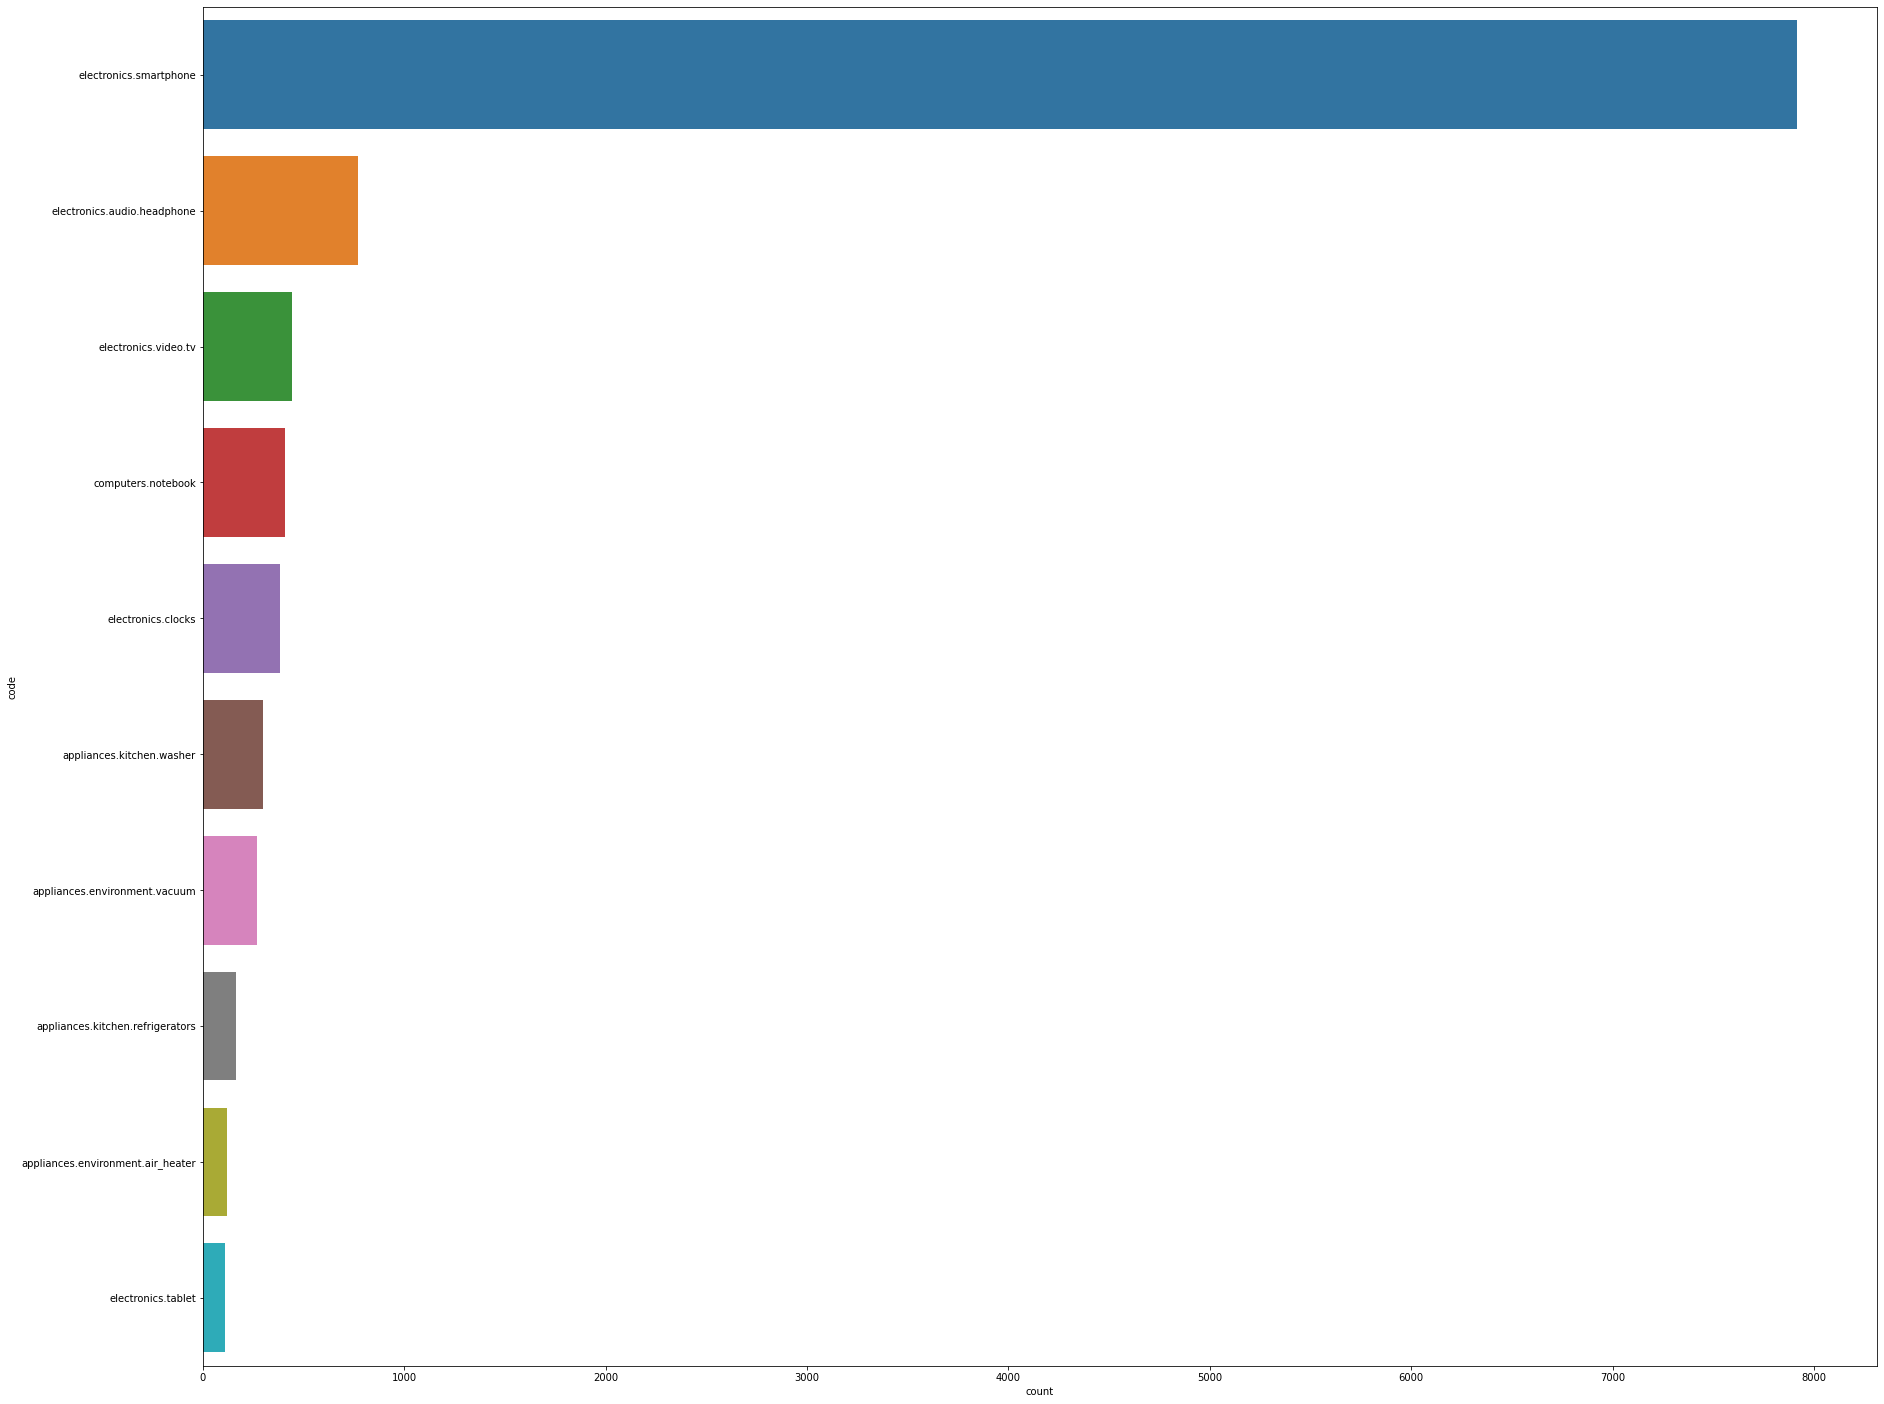

In [ ]:

top_10_codes = df_samsung_purchase['code'].value_counts().nlargest(10)
plt.figure(figsize=(30,25))
sns.countplot(y='code', data=df_samsung_purchase, order=top_10_codes.index)

In [ ]:
df_purchase_count = df_samsung_purchase.groupby("code").size().reset_index(name='counts')
df_purchase_count = df_purchase_count.sort_values(by='counts', ascending=False)
df_purchase_count

,code,counts
73,electronics.smartphone,7916
67,electronics.audio.headphone,771
77,electronics.video.tv,443
51,computers.notebook,407
72,electronics.clocks,383
...,...,...
64,country_yard.cultivator,1
1,accessories.umbrella,1
29,appliances.kitchen.steam_cooker,1
38,auto.accessories.parktronic,1


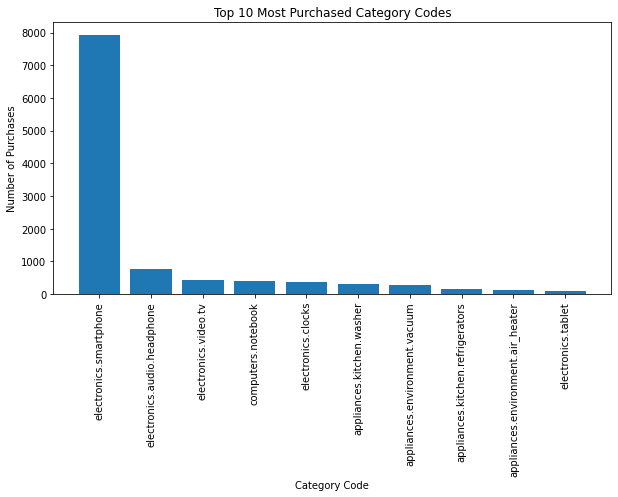

In [ ]:
df_purchase_count_top10 = df_purchase_count.head(10)

plt.figure(figsize=(10,5))
plt.bar(df_purchase_count_top10['code'], df_purchase_count_top10['counts'])
plt.xlabel('Category Code')
plt.ylabel('Number of Purchases')
plt.title('Top 10 Most Purchased Category Codes')
plt.xticks(rotation=90)
plt.show()
